# Stage 2.0 — EDA preparation

This notebook defines the **analysis frame** for Stage 2 EDA and prepares canonical slices from sanitized daily data + quality labels. It also provides a compact coverage/readiness overview used by later notebooks.

Scope in Stage 2 plan:
- **Block A (Analysis frame / setup)**: inputs, slice definitions, semantics, derived features
- **Early Block B (Coverage-aware overview)**: readiness summary, date ranges, missingness tables


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from garmin_analytics.eda import prepare as eda_prepare

add_derived_features = eda_prepare.add_derived_features
build_eda_frames = eda_prepare.build_eda_frames
eda_readiness_summary = eda_prepare.eda_readiness_summary
load_daily_sanitized = eda_prepare.load_daily_sanitized
load_quality = eda_prepare.load_quality

STRESS_TOTAL_ALIAS_MAP = getattr(
    eda_prepare,
    "STRESS_TOTAL_ALIAS_MAP",
    {
        "stress_total_avg_level": "allDayStress_TOTAL_averageStressLevel",
        "stress_total_total_duration_s": "allDayStress_TOTAL_totalDuration",
        "stress_total_stress_duration_s": "allDayStress_TOTAL_stressDuration",
        "stress_total_rest_s": "allDayStress_TOTAL_restDuration",
        "stress_total_low_s": "allDayStress_TOTAL_lowDuration",
        "stress_total_med_s": "allDayStress_TOTAL_mediumDuration",
        "stress_total_high_s": "allDayStress_TOTAL_highDuration",
        "stress_total_activity_s": "allDayStress_TOTAL_activityDuration",
        "stress_total_uncat_s": "allDayStress_TOTAL_uncategorizedDuration",
    },
)

pd.set_option('display.max_columns', 120)

## A. Analysis Contract (what this notebook defines)

This notebook establishes the shared analysis contract for Stage 2. Later notebooks should reuse these conventions instead of redefining slices ad hoc.

### Inputs
- `daily_sanitized.parquet` (preferred; privacy-safe default)
- `daily.parquet` (fallback only if sanitized is unavailable)
- `daily_quality.parquet` (Stage 1 quality labels + diagnostics)

### Grain and semantics
- **One row = one calendar day** (`calendarDate`)
- Sleep fields are treated as day-level attributes aligned to `calendarDate` in the merged daily table
- Quality labels are interpreted as **analysis-readiness / signal-coverage** labels (not physiological quality scores)

### Canonical slices produced here
- `df_all`: all joined days (sanitized + quality columns)
- `df_strict`: days passing strict quality validity and not flagged as corrupted stress-only artifacts
- `df_sleep`: days with sleep coverage (`has_sleep=True`) and not flagged as corrupted stress-only artifacts
- `df_loose` is intentionally not materialized here yet; if needed in later notebooks, derive it explicitly from `valid_day_loose` using the same artifact exclusion rule

### Why this matters
- keeps Stage 2 charts comparable across notebooks
- makes quality filtering explicit
- reduces repeated prep code and slice drift


In [2]:
def _find_repo_root(start: Path) -> Path:
    """Find repo root by looking for pyproject.toml (works from notebooks or repo root cwd)."""
    for candidate in [start, *start.parents]:
        if (candidate / "pyproject.toml").exists():
            return candidate
    # Fallback for older notebook behavior; keeps notebook usable in ad hoc sessions.
    return (start / "..").resolve()

repo_root = _find_repo_root(Path.cwd().resolve())
print('Repo root:', repo_root)
daily_sanitized_path = repo_root / "data/processed/daily_sanitized.parquet"
daily_fallback_path = repo_root / "data/processed/daily.parquet"
quality_path = repo_root / "data/processed/daily_quality.parquet"

daily_path = daily_sanitized_path if daily_sanitized_path.exists() else daily_fallback_path
if not daily_path.exists():
    raise FileNotFoundError(f"Daily parquet not found: {daily_path}")
if not quality_path.exists():
    raise FileNotFoundError(f"Quality parquet not found: {quality_path}")

daily_df = load_daily_sanitized(daily_path)
quality_df = load_quality(quality_path)

assert daily_df['calendarDate'].duplicated().sum() == 0, 'daily has duplicate calendarDate rows'
assert quality_df['calendarDate'].duplicated().sum() == 0, 'quality has duplicate calendarDate rows'

print('Daily input:', daily_path)
print('Quality input:', quality_path)
print('daily rows:', len(daily_df), 'quality rows:', len(quality_df))


Repo root: /Users/abatrakov/Documents/FUN/wearable-analytics
Daily input: /Users/abatrakov/Documents/FUN/wearable-analytics/data/processed/daily_sanitized.parquet
Quality input: /Users/abatrakov/Documents/FUN/wearable-analytics/data/processed/daily_quality.parquet
daily rows: 580 quality rows: 580


### Build canonical EDA slices

We join sanitized daily rows with Stage 1 quality outputs, then create the canonical slices used across Stage 2. Derived features are added **after** slicing to keep transformations consistent across all slices.

Artifact handling rule used here:
- rows flagged as `corrupted_stress_only_day` are excluded from analysis slices (`df_strict`, `df_sleep`)


In [3]:
frames = build_eda_frames(daily_df, quality_df, strict_min_score=4, loose_min_score=3)

df_all = add_derived_features(frames['df_all'])
df_strict = add_derived_features(frames['df_strict'])
df_sleep = add_derived_features(frames['df_sleep'])

frames = {'df_all': df_all, 'df_strict': df_strict, 'df_sleep': df_sleep}

for name, frame in frames.items():
    print(f'{name}: {len(frame)} rows')

df_all: 580 rows
df_strict: 525 rows
df_sleep: 474 rows


### Slice semantics and intended use

- `df_all`: baseline reference slice for coverage/missingness checks and broad diagnostics
- `df_strict`: preferred default for trend/distribution charts where data completeness matters
- `df_sleep`: sleep-specific analyses (sleep scores/stages/respiration during sleep)

Recommended convention for later notebooks:
- if a chart is based on `df_all`, say so explicitly (because missingness can materially affect interpretation)
- if a chart is based on `df_strict` or `df_sleep`, mention the filter in the section header or caption


### Core analysis fields (working preview scope)

The next cells define a compact set of core columns for Stage 2 review (identity/quality, movement, stress, heart rate, body battery, sleep) plus derived aliases/metrics. This is a convenience preview layer, not a replacement for the full data dictionary.


In [4]:
def _prefer_alias(alias: str, original: str, columns: pd.Index) -> str:
    if alias in columns:
        return alias
    return original

key_cols = [
    # identity / quality
    "calendarDate", "quality_score", "valid_day_strict", "has_sleep", "corrupted_stress_only_day",

    # movement
    "totalSteps", "totalDistanceMeters", "activeSeconds", "highlyActiveSeconds",

    # stress (summary + breakdown TOTAL)
    "stressTotalDurationSeconds",
    _prefer_alias("stress_total_avg_level", "allDayStress_TOTAL_averageStressLevel", df_all.columns),
    _prefer_alias("stress_total_rest_s", "allDayStress_TOTAL_restDuration", df_all.columns),
    _prefer_alias("stress_total_low_s", "allDayStress_TOTAL_lowDuration", df_all.columns),
    _prefer_alias("stress_total_med_s", "allDayStress_TOTAL_mediumDuration", df_all.columns),
    _prefer_alias("stress_total_high_s", "allDayStress_TOTAL_highDuration", df_all.columns),
    _prefer_alias("stress_total_activity_s", "allDayStress_TOTAL_activityDuration", df_all.columns),
    _prefer_alias("stress_total_uncat_s", "allDayStress_TOTAL_uncategorizedDuration", df_all.columns),

    # heart rate
    "restingHeartRate", "minHeartRate", "maxHeartRate", "minAvgHeartRate", "maxAvgHeartRate",

    # body battery
    "bodyBatteryStartOfDay", "bodyBatteryEndOfDay", "bodyBatteryLowest", "bodyBatteryHighest",

    # sleep
    "sleepStartTimestampGMT", "sleepEndTimestampGMT",
    "deepSleepSeconds", "lightSleepSeconds", "remSleepSeconds", "awakeSleepSeconds",
    "sleepOverallScore", "avgSleepStress",
]

present_key_cols = [c for c in key_cols if c in df_all.columns]
missing_key_cols = [c for c in key_cols if c not in df_all.columns]
if missing_key_cols:
    print("Warning: missing expected key columns:", missing_key_cols)

derived_cols = [
    "stress_hours", "steps_k", "distance_km", "bb_delta",
    "sleep_total_hours", "sleep_efficiency", "deep_pct", "light_pct",
    "rem_pct", "awake_pct",
]
present_derived_cols = [c for c in derived_cols if c in df_all.columns]

preview_cols = list(dict.fromkeys(present_key_cols + present_derived_cols))

# Vertical-friendly preview: fields go top-to-bottom, example rows go left-to-right
preview_source = df_all[preview_cols].head(10).copy()
preview_source.index = [f"row_{i+1}" for i in range(len(preview_source))]
preview_vertical = preview_source.T
preview_vertical

,row_1,row_2,row_3,row_4,row_5,row_6,row_7,row_8,row_9,row_10
calendarDate,2023-05-26 00:00:00,2023-05-27 00:00:00,2023-05-28 00:00:00,2023-05-29 00:00:00,2023-05-30 00:00:00,2023-05-31 00:00:00,2023-06-01 00:00:00,2023-06-02 00:00:00,2023-06-03 00:00:00,2023-06-04 00:00:00
quality_score,4,5,5,5,5,5,4,5,5,5
valid_day_strict,True,True,True,True,True,True,True,True,True,True
has_sleep,False,True,True,True,True,True,True,True,True,True
corrupted_stress_only_day,False,False,False,False,False,False,False,False,False,False
totalSteps,1096,20915,5935,17593,9212,13653,15278,13372,13948,7073
totalDistanceMeters,863,17337,5044,14366,7196,11586,12642,10742,10968,6599
activeSeconds,1285,6453,1321,5498,3372,2300,4627,4405,7854,2405
highlyActiveSeconds,797,5638,2700,3993,1751,5238,3986,3049,268,2061
stressTotalDurationSeconds,22080,84840,85440,85740,85980,86100,85680,85620,85380,85620


In [5]:
alias_mapping_table = pd.DataFrame(
    [{"alias": alias, "original": original} for alias, original in STRESS_TOTAL_ALIAS_MAP.items()]
 )
alias_mapping_table["used_column"] = alias_mapping_table.apply(
    lambda r: r["alias"] if r["alias"] in df_all.columns else (r["original"] if r["original"] in df_all.columns else None),
    axis=1,
 )
alias_mapping_table

,alias,original,used_column
0,stress_total_avg_level,allDayStress_TOTAL_averageStressLevel,stress_total_avg_level
1,stress_total_total_duration_s,allDayStress_TOTAL_totalDuration,stress_total_total_duration_s
2,stress_total_stress_duration_s,allDayStress_TOTAL_stressDuration,stress_total_stress_duration_s
3,stress_total_rest_s,allDayStress_TOTAL_restDuration,stress_total_rest_s
4,stress_total_low_s,allDayStress_TOTAL_lowDuration,stress_total_low_s
5,stress_total_med_s,allDayStress_TOTAL_mediumDuration,stress_total_med_s
6,stress_total_high_s,allDayStress_TOTAL_highDuration,stress_total_high_s
7,stress_total_activity_s,allDayStress_TOTAL_activityDuration,stress_total_activity_s
8,stress_total_uncat_s,allDayStress_TOTAL_uncategorizedDuration,stress_total_uncat_s


## B. Coverage-aware overview (tables-first baseline)

This section provides compact readiness diagnostics before deeper EDA plotting:
- slice sizes and shares
- date coverage per slice
- missingness across core analysis fields

These are the minimum checks that help interpret later charts honestly. (Coverage visuals will be added in a later pass.)


In [6]:
summary = eda_readiness_summary(frames)
summary

,rows_all,rows_strict,rows_sleep,strict_good_pct,sleep_present_pct,corrupted_pct
0,580,525,474,90.517241,81.724138,3.62069


In [7]:
date_ranges = pd.DataFrame([
    {
        'slice': name,
        'rows': len(frame),
        'date_min': frame['calendarDate'].min(),
        'date_max': frame['calendarDate'].max(),
    }
    for name, frame in frames.items()
])
date_ranges

,slice,rows,date_min,date_max
0,df_all,580,2023-05-26,2026-02-05
1,df_strict,525,2023-05-26,2026-02-05
2,df_sleep,474,2023-05-27,2026-02-05


In [8]:
def _missingness_table(frame: pd.DataFrame, cols: list[str], top_n: int = 20) -> pd.DataFrame:
    rows = []
    for c in cols:
        s = frame[c]
        rows.append({
            "column": c,
            "missing_count": int(s.isna().sum()),
            "missing_pct": round(float(s.isna().mean() * 100.0), 2),
            "n_unique": int(s.nunique(dropna=True)),
        })
    out = pd.DataFrame(rows).sort_values("missing_pct", ascending=False).head(top_n)
    return out.reset_index(drop=True)

for slice_name, frame in frames.items():
    print(f"\nMissingness over core columns — {slice_name}")
    display(_missingness_table(frame, present_key_cols, top_n=20))


Missingness over core columns — df_all


,column,missing_count,missing_pct,n_unique
0,remSleepSeconds,113,19.48,179
1,sleepOverallScore,107,18.45,63
2,avgSleepStress,106,18.28,415
3,awakeSleepSeconds,106,18.28,83
4,lightSleepSeconds,106,18.28,242
5,deepSleepSeconds,106,18.28,109
6,sleepEndTimestampGMT,106,18.28,474
7,sleepStartTimestampGMT,106,18.28,474
8,bodyBatteryEndOfDay,83,14.31,48
9,stress_total_rest_s,46,7.93,349



Missingness over core columns — df_strict


,column,missing_count,missing_pct,n_unique
0,remSleepSeconds,58,11.05,179
1,sleepOverallScore,52,9.90,63
2,avgSleepStress,51,9.71,415
3,awakeSleepSeconds,51,9.71,83
4,lightSleepSeconds,51,9.71,242
5,deepSleepSeconds,51,9.71,109
6,sleepEndTimestampGMT,51,9.71,474
7,sleepStartTimestampGMT,51,9.71,474
8,bodyBatteryEndOfDay,36,6.86,46
9,stress_total_rest_s,7,1.33,338



Missingness over core columns — df_sleep


,column,missing_count,missing_pct,n_unique
0,bodyBatteryEndOfDay,36,7.59,44
1,remSleepSeconds,7,1.48,179
2,restingHeartRate,1,0.21,21
3,sleepOverallScore,1,0.21,63
4,stress_total_rest_s,1,0.21,305
5,bodyBatteryLowest,0,0.00,30
6,minAvgHeartRate,0,0.00,21
7,maxAvgHeartRate,0,0.00,86
8,bodyBatteryStartOfDay,0,0.00,47
9,sleepStartTimestampGMT,0,0.00,474


### Coverage-aware overview visuals

The charts below summarize how Stage 1 quality filtering changes the usable analysis set and how key signal coverage varies over time. This helps interpret later EDA plots without hiding missingness effects.


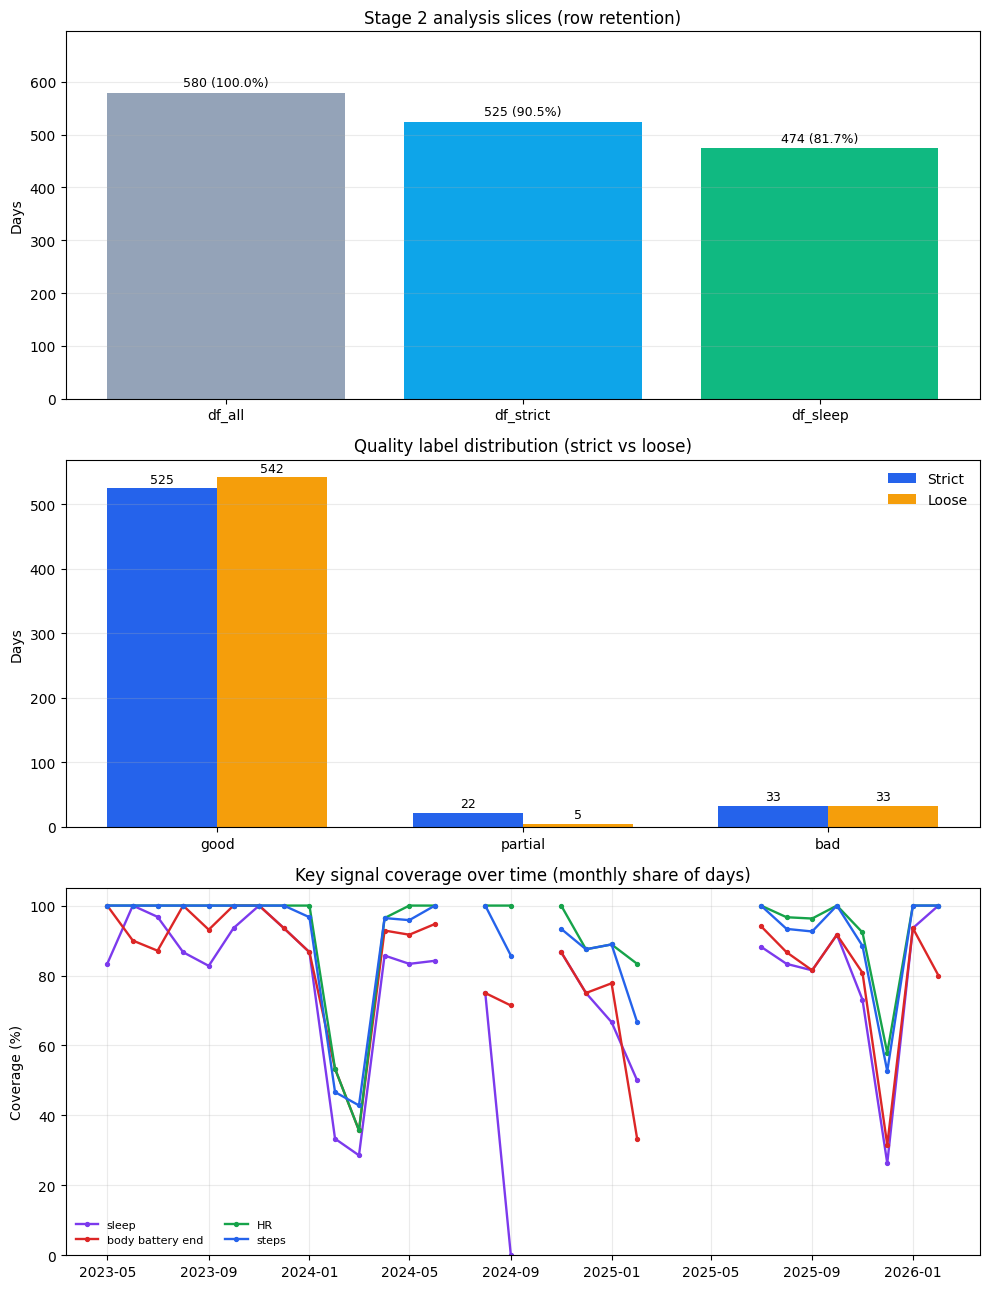

In [9]:
# Block B visuals: slice retention, quality label distribution, and monthly key-signal coverage
plt.style.use("default")

slice_counts = pd.Series({name: len(frame) for name, frame in frames.items()})
slice_base = int(slice_counts.get("df_all", 0)) or 1

fig, axes = plt.subplots(3, 1, figsize=(10, 13))

# 1) Slice retention
ax = axes[0]
labels = ["df_all", "df_strict", "df_sleep"]
counts = [int(slice_counts.get(label, 0)) for label in labels]
colors = ["#94a3b8", "#0ea5e9", "#10b981"]
bars = ax.bar(labels, counts, color=colors)
ax.set_title("Stage 2 analysis slices (row retention)")
ax.set_ylabel("Days")
ax.set_ylim(0, max(counts) * 1.2 if counts else 1)
for bar, count in zip(bars, counts):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 6,
        f"{count} ({count / slice_base * 100:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=9,
    )
ax.grid(axis="y", alpha=0.25)

# 2) Quality label distribution (strict vs loose)
ax = axes[1]
order = ["good", "partial", "bad"]
strict_counts = df_all["day_quality_label_strict"].astype(str).value_counts().reindex(order, fill_value=0)
loose_counts = df_all["day_quality_label_loose"].astype(str).value_counts().reindex(order, fill_value=0)
x = np.arange(len(order))
width = 0.36
ax.bar(x - width / 2, strict_counts.values, width, label="Strict", color="#2563eb")
ax.bar(x + width / 2, loose_counts.values, width, label="Loose", color="#f59e0b")
ax.set_xticks(x)
ax.set_xticklabels(order)
ax.set_ylabel("Days")
ax.set_title("Quality label distribution (strict vs loose)")
ax.legend(frameon=False)
ax.grid(axis="y", alpha=0.25)
for i, v in enumerate(strict_counts.values):
    ax.text(i - width / 2, v + 4, str(int(v)), ha="center", va="bottom", fontsize=9)
for i, v in enumerate(loose_counts.values):
    ax.text(i + width / 2, v + 4, str(int(v)), ha="center", va="bottom", fontsize=9)

# 3) Monthly coverage of key signals (share of days with signal present)
ax = axes[2]
coverage_cols = [c for c in ["has_sleep", "has_bodybattery_end", "has_hr", "has_steps"] if c in df_all.columns]
coverage_df = df_all[["calendarDate", *coverage_cols]].copy()
coverage_df["calendarDate"] = pd.to_datetime(coverage_df["calendarDate"], errors="coerce")
coverage_df = coverage_df.dropna(subset=["calendarDate"]).sort_values("calendarDate").set_index("calendarDate")
for c in coverage_cols:
    coverage_df[c] = coverage_df[c].astype("boolean").fillna(False).astype(int)
monthly_cov = coverage_df.resample("MS").mean() * 100.0
label_map = {
    "has_sleep": "sleep",
    "has_bodybattery_end": "body battery end",
    "has_hr": "HR",
    "has_steps": "steps",
}
color_map = {
    "has_sleep": "#7c3aed",
    "has_bodybattery_end": "#dc2626",
    "has_hr": "#16a34a",
    "has_steps": "#2563eb",
}
for c in coverage_cols:
    ax.plot(
        monthly_cov.index, monthly_cov[c],
        marker="o", markersize=2.8, linewidth=1.7,
        label=label_map.get(c, c),
        color=color_map.get(c),
    )
ax.set_ylim(0, 105)
ax.set_ylabel("Coverage (%)")
ax.set_title("Key signal coverage over time (monthly share of days)")
ax.grid(alpha=0.25)
ax.legend(ncol=2, frameon=False, fontsize=8)

fig.tight_layout()
plt.show()


### GitHub-style daily calendar (coverage + quality)

This calendar view complements monthly coverage lines by showing **day-level structure**. It is especially useful for spotting:
- periods when the watch was not worn at all
- clusters of partial/bad days
- repeated charge-cycle patterns (e.g., quality drops when the watch battery dies before recharging)

Color meaning (quality-aware):
- dark navy = no wear / no corroborating signals
- red = worn but strict-bad day
- amber = partial / borderline day
- green shades = strict-good days (darker = score 4, brighter = score 5)
- light outline = `corrupted_stress_only_day`


In [ ]:
# GitHub-style calendar heatmap of daily coverage + quality
from matplotlib.patches import FancyBboxPatch

def _build_calendar_quality_view(frame: pd.DataFrame) -> pd.DataFrame:
    required = ["calendarDate", "day_quality_label_strict", "quality_score"]
    missing = [c for c in required if c not in frame.columns]
    if missing:
        raise KeyError(f"Missing columns for calendar heatmap: {missing}")

    df = frame.copy()
    df["calendarDate"] = pd.to_datetime(df["calendarDate"], errors="coerce").dt.normalize()
    df = df.dropna(subset=["calendarDate"]).sort_values("calendarDate")

    wear_proxy_cols = [c for c in ["has_steps", "has_hr", "has_sleep", "has_bodybattery_start"] if c in df.columns]
    if wear_proxy_cols:
        wear_proxy = df[wear_proxy_cols].astype("boolean").fillna(False).any(axis=1)
    else:
        wear_proxy = pd.Series(False, index=df.index)

    strict_label = df["day_quality_label_strict"].astype(str)
    score = pd.to_numeric(df["quality_score"], errors="coerce")
    category = pd.Series(0, index=df.index, dtype="int64")
    category[(wear_proxy) & (strict_label == "bad")] = 1
    category[strict_label == "partial"] = 2
    category[(strict_label == "good") & (score == 4)] = 3
    category[(strict_label == "good") & (score >= 5)] = 4

    corrupted = df["corrupted_stress_only_day"].astype("boolean").fillna(False) if "corrupted_stress_only_day" in df.columns else pd.Series(False, index=df.index, dtype="boolean")

    out = pd.DataFrame({
        "date": df["calendarDate"],
        "category": category,
        "corrupted": corrupted.astype(bool),
    }).set_index("date")
    return out

def plot_quality_calendar_heatmap(frame: pd.DataFrame):
    cal = _build_calendar_quality_view(frame)
    if cal.empty:
        raise ValueError("No rows available for calendar heatmap")

    min_date = cal.index.min().date()
    max_date = cal.index.max().date()
    years = list(range(min_date.year, max_date.year + 1))

    BG = "#06111f"
    PANEL_BG = "#081829"
    GRID_EMPTY = "#0f2135"
    TEXT = "#e5edf7"
    MUTED = "#9fb0c4"
    PALETTE = {
        0: "#0b1a2b",  # no wear / no corroborating signals
        1: "#7f1d1d",  # worn but strict-bad
        2: "#b45309",  # partial / borderline
        3: "#15803d",  # strict good (score 4)
        4: "#4ade80",  # strict good (score 5)
    }

    n_years = len(years)
    fig_h = 2.35 * n_years + 0.9
    fig = plt.figure(figsize=(15, fig_h), facecolor=BG)
    gs = fig.add_gridspec(n_years, 1, hspace=0.38)
    month_abbr = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

    for row_idx, year in enumerate(years):
        ax = fig.add_subplot(gs[row_idx, 0])
        ax.set_facecolor(PANEL_BG)

        jan1 = pd.Timestamp(year=year, month=1, day=1)
        dec31 = pd.Timestamp(year=year, month=12, day=31)
        year_days = pd.date_range(jan1, dec31, freq="D")
        jan1_weekday = jan1.weekday()  # Mon=0
        def _week_of(d):
            return ((d - jan1).days + jan1_weekday) // 7

        size = 0.82
        rounding = 0.15
        max_week = int(max(_week_of(d) for d in year_days))

        # background grid
        for d in year_days:
            x = _week_of(d)
            y = d.weekday()
            ax.add_patch(FancyBboxPatch((x + (1-size)/2, y + (1-size)/2), size, size,
                boxstyle=f"round,pad=0,rounding_size={rounding}", linewidth=0.4, edgecolor=PANEL_BG, facecolor=GRID_EMPTY))

        # observed daily values
        year_view = cal[(cal.index >= jan1) & (cal.index <= dec31)]
        for d, row in year_view.iterrows():
            x = _week_of(d)
            y = d.weekday()
            edge = "#d1d5db" if bool(row["corrupted"]) else PANEL_BG
            lw = 0.8 if bool(row["corrupted"]) else 0.4
            ax.add_patch(FancyBboxPatch((x + (1-size)/2, y + (1-size)/2), size, size,
                boxstyle=f"round,pad=0,rounding_size={rounding}", linewidth=lw, edgecolor=edge, facecolor=PALETTE[int(row["category"])]))

        # month labels
        for m in range(1, 13):
            m_date = pd.Timestamp(year=year, month=m, day=1)
            ax.text(_week_of(m_date), -0.9, month_abbr[m-1], color=TEXT, fontsize=9, ha="left", va="center")

        # weekday labels (sparse)
        for y_idx, label in [(0, "Mon"), (2, "Wed"), (4, "Fri")]:
            ax.text(-1.35, y_idx + 0.5, label, color=TEXT, fontsize=9, ha="right", va="center")

        ax.text(-4.55, 3.5, str(year), color=TEXT, fontsize=11, fontweight="bold", ha="left", va="center")
        ax.set_xlim(-0.5, max_week + 1.5)
        ax.set_ylim(7.3, -1.6)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

    fig.suptitle("Daily Garmin data coverage & quality calendar (GitHub-style)", color=TEXT, fontsize=16, y=0.992)

    legend_ax = fig.add_axes([0.06, 0.004, 0.88, 0.085])
    legend_ax.set_facecolor(BG)
    legend_ax.axis("off")
    legend_items = [
        ("No wear / no corroborating signals", PALETTE[0]),
        ("Worn but strict-bad day", PALETTE[1]),
        ("Partial / borderline day", PALETTE[2]),
        ("Strict good (score=4)", PALETTE[3]),
        ("Strict good (score=5)", PALETTE[4]),
    ]
    x = 0.0
    x_steps = [0.24, 0.20, 0.19, 0.16, 0.15]
    for (label, color), step in zip(legend_items, x_steps):
        legend_ax.add_patch(FancyBboxPatch((x, 0.48), 0.018, 0.30, boxstyle="round,pad=0,rounding_size=0.02", facecolor=color, edgecolor="none"))
        legend_ax.text(x + 0.024, 0.63, label, color=MUTED, fontsize=8.4, va="center", ha="left")
        x += step
    legend_ax.text(0.0, 0.15, "Outline = corrupted stress-only day", color=MUTED, fontsize=8, ha="left", va="center")

    return fig

calendar_fig = plot_quality_calendar_heatmap(df_all)
plt.show()


### Block B findings (current dataset)

- `df_strict` retains most days (about **90.5%** of `df_all`), so strict filtering is usable as a default analysis slice rather than a niche subset.
- `df_sleep` is smaller (about **81.7%** of `df_all`), so sleep-specific analyses should explicitly state this narrower coverage and avoid direct comparison with all-day metrics without noting the filter.
- The gap between strict and loose labels is concentrated in `partial` days (strict: **22**, loose: **5**), which confirms that the two thresholds mainly affect borderline coverage cases rather than obviously bad days.
- Monthly key-signal coverage is not stable over time (especially `has_sleep` and `has_bodybattery_end`), so later trend/distribution plots should state the slice/filter used and avoid over-interpreting sparse periods.
- The calendar heatmap reveals day-level structure that monthly lines hide: isolated week-long clusters and periodic quality dips are consistent with real watch charging behavior (battery lasting about a week, then partial days when the device dies before recharging).
- Long dark stretches correspond to periods when the watch was likely not worn (or not charged) for extended time windows, which should be treated as coverage gaps rather than behavioral evidence.


## Optional local preview export (OFF by default)

Set `EXPORT_PREVIEW = True` to write a small local CSV preview to `data/interim` (gitignored).

In [10]:
EXPORT_PREVIEW = False

if EXPORT_PREVIEW:
    out_path = repo_root / 'data/interim/eda_prepare_preview.csv'
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df_all[preview_cols].head(200).to_csv(out_path, index=False)
    print('Wrote', out_path)
else:
    print('Preview export disabled (default).')

Preview export disabled (default).
